In [1]:
%load_ext autoreload
%autoreload 2


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }<\style>"))
import argparse
import os
import pandas as pd

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from PIL import Image
import tqdm


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1,2'

In [3]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from collections import OrderedDict
from torch.nn.functional import one_hot as one_hot
import torch.utils.data as data
import utils
from model import * 
from utils import *

In [4]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
        base = models.resnet18(pretrained=True)
        base.fc = nn.Linear(512, 512)
        
        self.model = base
        self.finalLayer = nn.Linear(512, 256)
            
    def forward(self, x, sens = None):
        feature = self.model(x)
        output = self.finalLayer(torch.relu(feature))
            
        return F.normalize(feature, dim = -1), F.normalize(output, dim = -1)

In [5]:
class Net(nn.Module):
    def __init__(self, num_class, pretrained_path = None):
        super(Net, self).__init__()

        # encoder
        model = Image_Model().cuda()
        model = nn.DataParallel(model)
        if pretrained_path is not None:
            model.load_state_dict(torch.load(pretrained_path, map_location='cuda:0'))
       # self.f=model.f
        self.f = model.module.model
        # classifier
        self.fc = nn.Linear(512, num_class, bias=True)

    def forward(self, x):
        x = self.f(x)
        feature = torch.flatten(x, start_dim=1)
        out = self.fc(feature)
        return out

In [6]:
cls = Net(2)
cls = nn.DataParallel(cls).cuda()

In [6]:
batch_size = 128
device = 'cuda:0'
tau_plus = 0.1
dataset_name = 'celeba'
beta =0.9
estimator = 'hard'
temperature =0.7
epochs = 400


## Eval Hard samples?

In [7]:
model_d = Image_Model().cuda()
model_d = nn.DataParallel(model_d)
model_d.load_state_dict(torch.load(os.path.join("../results", dataset_name, 'wcl', 'no_orient_new/celeba_model_d_256_0.1_0.001_20.pth')))
model_d.eval()

model_b = Image_Model().cuda()
model_b = nn.DataParallel(model_b)
model_b.load_state_dict(torch.load(os.path.join("../results", dataset_name, 'wcl', 'no_orient_new/celeba_model_b_256_0.1_0.01_20.pth')))
model_b.eval()


DataParallel(
  (module): Image_Model(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Bat

In [8]:
train_data, memory_data, test_data = utils.get_dataset('celeba', root='../data', pair = False)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True, drop_last=True)
memory_loader = DataLoader(memory_data, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)

k = 200
c = len(memory_data.classes)

/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/torchvision/transforms/transforms.py:852: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [9]:
def get_negative_mask(batch_size):
    negative_mask = torch.ones((batch_size, 1 * batch_size), dtype=bool)
    for i in range(batch_size):
        negative_mask[i, i] = 0
#         negative_mask[i, i + batch_size] = 0
#     negative_mask = torch.cat((negative_mask, negative_mask), 0)
    return negative_mask

def triplet(out_1,out_2,tau_plus,batch_size,temperature, debias = True):
    N = batch_size * 2 - 2
    out = torch.cat([out_1, out_2], dim=0) # 2 * bs x fs
    s = torch.pow(out.unsqueeze(0) - out.unsqueeze(1), 2).sum(-1) # 2 * bs x 2 * bs
    mask = get_negative_mask(batch_size).to(device)
    
    if debias:
        s = s.masked_select(mask).view(2 * batch_size, -1)  # (2 * bs, 2 * bs - 2) : subtract self and its augment

        pos = (torch.pow(out_1 - out_2, 2))
        pos = torch.cat([pos, pos], dim=0).sum(-1)

        neg = (-tau_plus * N * pos + s.sum(-1)) / (1 - tau_plus)

    else:
        neg = s.masked_select(mask).view(2 * batch_size, -1)  # (2 * bs, 2 * bs - 2) : subtract self and its augment

        pos = (torch.pow(out_1 - out_2, 2))
        pos = torch.cat([pos, pos], dim=0).sum(-1)

    return (pos - neg).mean()

def W(out_d, out_b, batch_size):
    mask = get_negative_mask(batch_size).to(device)
    
#     difficulty by cosine similarity
    s_d = torch.exp(torch.mm(out_d, out_d.t().contiguous()) / temperature)
    s_d = s_d.masked_select(mask).view(1 * batch_size, -1) # (2 * bs, 2 * bs - 2) : subtract self and its augment
    s_d = F.normalize(s_d, dim = -1)
    
    s_b = torch.exp(torch.mm(out_b, out_b.t().contiguous()) / temperature)
    s_b = s_b.masked_select(mask).view(1 * batch_size, -1) # (2 * bs, 2 * bs - 2) : subtract self and its augment
    s_b = F.normalize(s_b, dim = -1)
    
    weight = 1 + s_d / (s_b + s_d + 1e-6)
#     print(weight)
    if np.isnan(weight.sum().item()):
        print('weight NaN')
        
    return weight.detach()

def criterion(out_1_d, out_2_d, out_1_b, out_2_b, tau_plus, batch_size, beta, temperature):
    # neg score
    out = torch.cat([out_1_d, out_2_d], dim=0)
    out_b = torch.cat([out_1_b, out_2_b], dim=0)
    neg = torch.exp(torch.mm(out, out.t().contiguous()) / temperature)
    mask = get_negative_mask(batch_size).to(device)
    neg = neg.masked_select(mask).view(2 * batch_size, -1) # (2 * bs, bs - 2) : subtract self and its augment

    # pos score
    pos = torch.exp(torch.sum(out_1_d * out_2_d, dim=-1) / temperature)
    pos = torch.cat([pos, pos], dim=0)
    
    weight = W(out, out_b, batch_size) # (2 * bs, bs - 2)

    # negative samples similarity scoring
    N = batch_size * 2 - 2
#         imp = (beta* neg.log()).exp()
#         reweight_neg = (imp*neg).sum(dim = -1) / imp.mean(dim = -1)
    reweight_neg = weight * neg

    Ng = (-tau_plus * N * pos + reweight_neg.sum(dim = -1)) / (1 - tau_plus)
    # constrain (optional)
    Ng = torch.clamp(Ng, min = N * np.e**(-1 / temperature))

    # contrastive loss
    loss = (-torch.log(pos / (pos + Ng) )).mean()

    return loss

In [14]:
Anchor_dict = dict()

with torch.no_grad():
    for x, s, y in test_loader:
        x, s, y = x.cuda(), s.cuda(), y.cuda()
        bs = x.shape[0]
        
        class_id = s + 2 * y
        feature_d, out = model_d(x)
        feature_b, out_b = model_b(x)

        neg = torch.exp(torch.mm(out, out.t().contiguous()) / temperature)
        weight = W(out, out_b, bs) # (bs, bs - 1)
        
        for i, cls_id in enumerate(class_id):
            cls_id = cls_id.item()
            if cls_id not in Anchor_dict.keys():
                Anchor_dict[cls_id] = {'N':[], 'N_class':[], 'P':[]}
                
            cls_idx = class_id == cls_id
            mask = torch.ones((bs,), dtype=bool).cuda()
            mask[i] = 0
            cls_idx = cls_idx.masked_select(mask)
            
            Anchor_dict[cls_id]['N'].append(weight[i][~cls_idx].detach().cpu())
            Anchor_dict[cls_id]['N_class'].append(class_id.masked_select(mask)[~cls_idx].detach().cpu())
            Anchor_dict[cls_id]['P'].append(weight[i][cls_idx].detach().cpu())
            
for key in Anchor_dict.keys():
    Anchor_dict[key]['N'] = torch.cat(Anchor_dict[key]['N']).numpy()
    Anchor_dict[key]['N_class'] = torch.cat(Anchor_dict[key]['N_class']).numpy()
    Anchor_dict[key]['P'] = torch.cat(Anchor_dict[key]['P']).numpy()

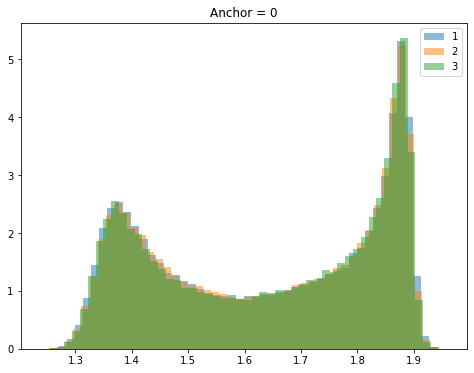

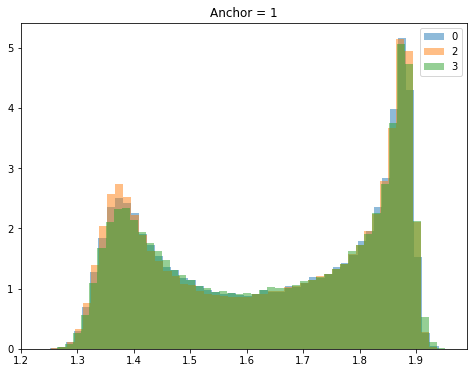

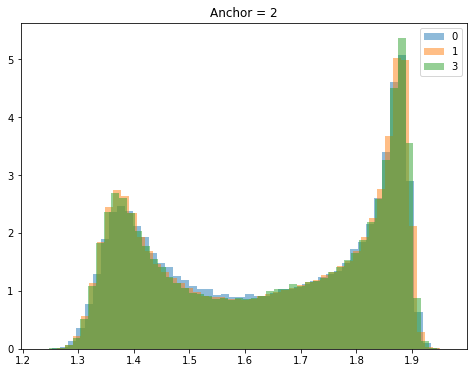

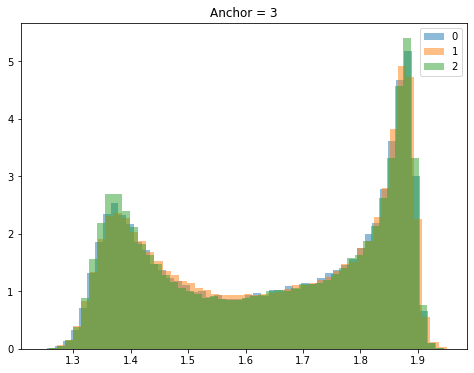

In [15]:
anchor_idx = 2

for anchor_idx in range(4):
    plt.figure(figsize = (8,6))
    for i in range(4):
        if i != anchor_idx:
            plt.hist(Anchor_dict[anchor_idx]['N'][Anchor_dict[anchor_idx]['N_class'] == i], bins = 50, alpha = 0.5, density = True, label = i )
    plt.legend()
    plt.title('Anchor = {}'.format(anchor_idx))
    plt.show()

## Cosine Similarlity

In [18]:
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

In [16]:
# model_d = Image_Model().cuda()
# model_d = nn.DataParallel(model_d)
# model_d.load_state_dict(torch.load(os.path.join("../results", dataset_name, 'wcl', 'no_orient_new/celeba_model_d_256_0.1_0.001_20.pth')))
# model_d.eval();

#HCL
# model_d = Image_Model().cuda()
# model_d = nn.DataParallel(model_d)
# model_d.load_state_dict(torch.load(os.path.join("../results", dataset_name, 'hcl', 'celeba_hard_model_256_0.3_1.0_20.pth')))
# model_d.eval();

#DCL
model_d = Image_Model().cuda()
model_d = nn.DataParallel(model_d)
model_d.load_state_dict(torch.load(os.path.join("../results", dataset_name, 'dcl', 'model_20.pth')))
model_d.eval();


In [13]:
feature_lst = list()
class_id_lst = list()
Anchor_dict = dict()

with torch.no_grad():
    for x, s, y in test_loader:
        x, s, y = x.cuda(), s.cuda(), y.cuda()
        bs = x.shape[0]
        
        class_id = s + 2 * y
        feature, out = model_d(x)

        feature_lst.append(feature)
        class_id_lst.append(class_id)
        
    feature_lst = torch.cat(feature_lst)
    class_id_lst = torch.cat(class_id_lst)
    bs = len(feature_lst)

cs_list = list()
for i in range(4):
    cs_diag = torch.triu(torch.mm(feature_lst[class_id_lst == i], feature_lst[class_id_lst == i].t().contiguous()), diagonal = +1)
    cs_diag = cs_diag[cs_diag != 0].detach().cpu()
    cs_list.append(cs_diag)
cs_list = torch.cat(cs_list).numpy()

n_cs_list = list()
for i in range(4):
    cs_diag = torch.triu(torch.mm(feature_lst[class_id_lst == i], feature_lst[class_id_lst != i].t().contiguous()))
    cs_diag = cs_diag[cs_diag != 0].detach().cpu()
    n_cs_list.append(cs_diag)
n_cs_list = torch.cat(n_cs_list).numpy()

#### HCL

In [15]:
feature_lst_hcl = list()
class_id_lst = list()

with torch.no_grad():
    for x, s, y in test_loader:
        x, s, y = x.cuda(), s.cuda(), y.cuda()
        bs = x.shape[0]
        
        class_id = s + 2 * y
        feature, out = model_d(x)

        feature_lst_hcl.append(feature)
        class_id_lst.append(class_id)
        
    feature_lst_hcl = torch.cat(feature_lst_hcl)
    class_id_lst = torch.cat(class_id_lst)
    bs = len(feature_lst_hcl)


cs_list_hcl = list()
for i in range(4):
    cs_diag = torch.triu(torch.mm(feature_lst_hcl[class_id_lst == i], feature_lst_hcl[class_id_lst == i].t().contiguous()), diagonal = +1)
    cs_diag = cs_diag[cs_diag != 0].detach().cpu()
    cs_list_hcl.append(cs_diag)
cs_list_hcl = torch.cat(cs_list_hcl).numpy()

n_cs_list_hcl = list()
for i in range(4):
    cs_diag = torch.triu(torch.mm(feature_lst_hcl[class_id_lst == i], feature_lst_hcl[class_id_lst != i].t().contiguous()))
    cs_diag = cs_diag[cs_diag != 0].detach().cpu()
    n_cs_list_hcl.append(cs_diag)
n_cs_list_hcl = torch.cat(n_cs_list_hcl).numpy()

#### DCL

In [17]:
feature_lst_dcl = list()
class_id_lst = list()

with torch.no_grad():
    for x, s, y in test_loader:
        x, s, y = x.cuda(), s.cuda(), y.cuda()
        bs = x.shape[0]
        
        class_id = s + 2 * y
        feature, out = model_d(x)

        feature_lst_dcl.append(feature)
        class_id_lst.append(class_id)
        
    feature_lst_dcl = torch.cat(feature_lst_dcl)
    class_id_lst = torch.cat(class_id_lst)
    bs = len(feature_lst_dcl)


cs_list_dcl = list()
for i in range(4):
    cs_diag = torch.triu(torch.mm(feature_lst_dcl[class_id_lst == i], feature_lst_dcl[class_id_lst == i].t().contiguous()), diagonal = +1)
    cs_diag = cs_diag[cs_diag != 0].detach().cpu()
    cs_list_dcl.append(cs_diag)
cs_list_dcl = torch.cat(cs_list_dcl).numpy()

n_cs_list_dcl = list()
for i in range(4):
    cs_diag = torch.triu(torch.mm(feature_lst_dcl[class_id_lst == i], feature_lst_dcl[class_id_lst != i].t().contiguous()))
    cs_diag = cs_diag[cs_diag != 0].detach().cpu()
    n_cs_list_dcl.append(cs_diag)
n_cs_list_dcl = torch.cat(n_cs_list_dcl).numpy()

array([8351,  232, 7642, ..., 7671, 5321, 2627])

/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function w

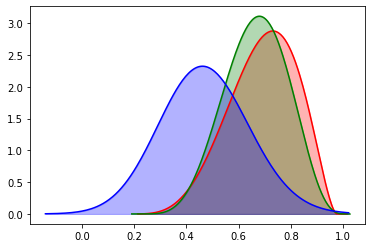

In [26]:
ax = sns.distplot(cs_list_dcl[np.random.randint(len(cs_list_dcl), size = (100000,))], fit_kws={"color":"red"}, kde=False,
        fit=stats.beta, hist=None, label="label 1");
ax = sns.distplot(cs_list_hcl[np.random.randint(len(cs_list_hcl), size = (100000,))], fit_kws={"color":"green"}, kde=False,
        fit=stats.beta, hist=None, label="label 1");
ax = sns.distplot(cs_list[np.random.randint(len(cs_list), size = (100000,))], fit_kws={"color":"blue"}, kde=False,
        fit=stats.gamma, hist=None, label="label 2");

# Get the two lines from the axes to generate shading
l1 = ax.lines[0]
l2 = ax.lines[1]
l3 = ax.lines[2]

# Get the xy data from the lines so that we can shade
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
x2 = l2.get_xydata()[:,0]
y2 = l2.get_xydata()[:,1]
x3 = l3.get_xydata()[:,0]
y3 = l3.get_xydata()[:,1]
ax.fill_between(x1,y1, color="red", alpha=0.3)
ax.fill_between(x2,y2, color="green", alpha=0.3)
ax.fill_between(x3,y3, color="blue", alpha=0.3)

plt.show(block=False)

In [ ]:
CUDA_VISIBLE_DEVICES=1,2 python linear.py --dataset_name imagenet --model_path ../results/imagenet/wcl/CVPR23/imagenet_model_d_256_0.01_0.5_0.001_0.001_100.pth --epochs 150

/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function w

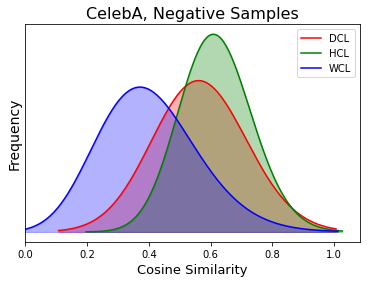

In [41]:
ax = sns.distplot(n_cs_list_dcl[np.random.randint(len(n_cs_list_dcl), size = (200000,))], fit_kws={"color":"red"}, kde=False,
        fit=stats.gamma, hist=None, label="DCL");
ax = sns.distplot(n_cs_list_hcl[np.random.randint(len(n_cs_list_hcl), size = (200000,))], fit_kws={"color":"green"}, kde=False,
        fit=stats.gamma, hist=None, label="HCL");
ax = sns.distplot(n_cs_list[np.random.randint(len(n_cs_list), size = (200000,))], fit_kws={"color":"blue"}, kde=False,
        fit=stats.gamma, hist=None, label="WCL");
# Get the two lines from the axes to generate shading
l1 = ax.lines[0]
l2 = ax.lines[1]
l3 = ax.lines[2]

# Get the xy data from the lines so that we can shade
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
x2 = l2.get_xydata()[:,0]
y2 = l2.get_xydata()[:,1]
x3 = l3.get_xydata()[:,0]
y3 = l3.get_xydata()[:,1]
ax.fill_between(x1,y1, color="red", alpha=0.3)
ax.fill_between(x2,y2, color="green", alpha=0.3)
ax.fill_between(x3,y3, color="blue", alpha=0.3)

plt.xlim(0.0)
plt.legend()
plt.xlabel('Cosine Similarity', fontsize = 13)
plt.ylabel('Frequency', fontsize = 14)
plt.title('CelebA, Negative Samples', fontsize=16)
plt.yticks([])
plt.savefig('figures/illust/cosine_celeba_negative.pdf', bbox_inches = 'tight')
plt.show(block=False)